<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Training_ALIGNN_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

1. Installing [ALIGNN](https://github.com/usnistgov/alignn)
2. Example training for regression on 50 materials,
3. Using more than 70 pre-trained models to make fast predictions
4. ALIGNN-FF Ase Calculator: predict energy/forces, optimized strcture, EV curves and phonons
5. Train ALIGNN-FF on a new dataset
6. Additional examples and dataset preparation example
7. Add ALIGNN-results to the JARVIS-Leaderboard

Author: Kamal Choudhary (kamal.choudhary@nist.gov)

## ALIGNN model ref.: https://www.nature.com/articles/s41524-021-00650-1
## ALIGNN-FF ref.: https://pubs.rsc.org/en/content/articlehtml/2023/dd/d2dd00096b

# 1. Installation

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


Bases on nvcc version, corresponding gpu version of dgl will be needed.

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [1]:
!conda --version

conda 23.11.0


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Takes about 6 minutes to install packages

In [3]:
%%time
!conda install alignn pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_0         105 KB  conda-forge
    aiohttp-3.9.5              |  py310h2372a71_0         682 KB  conda-forge
    aiosignal-1.3.1            |     pyhd8ed1ab_0          12 KB  conda-forge
    alignn-2024.4.10           |     pyhd8ed1ab_0          71 KB  conda-forge
    annotated-types-0.6.0      |     pyhd8ed1ab_0          17 KB  conda-forge
    ase-3.22.1                 |     pyhd8ed1ab_1         1.6 MB  conda-forge
    astunparse-1.6.3           |     pyh

In [ ]:
# %%time
# !pip install -q dgl==1.0.1+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html
# !pip install -q alignn phonopy

In [ ]:
# %%time
# !pip install --pre dgl -f https://data.dgl.ai/wheels/cu118/repo.html
# !pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html
# !pip install alignn phonopy

In [4]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/usnistgov/alignn.git

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

#!pip install dgl-cu111 # Colab has cuda 11.1

/content
Cloning into 'alignn'...
remote: Enumerating objects: 4585, done.
remote: Counting objects: 100% (1491/1491), done.
remote: Compressing objects: 100% (492/492), done.
remote: Total 4585 (delta 1190), reused 1099 (delta 975), pack-reused 3094
Receiving objects: 100% (4585/4585), 154.41 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (2744/2744), done.


Example folder with id_prop.csv and 'POSCAR files.'

In [5]:
!ls "alignn/examples/sample_data"

config_example.json	  POSCAR-JVASP-48166.vasp  POSCAR-JVASP-76312.vasp  POSCAR-JVASP-90228.vasp
id_prop.csv		  POSCAR-JVASP-50332.vasp  POSCAR-JVASP-76313.vasp  POSCAR-JVASP-90532.vasp
POSCAR-JVASP-107772.vasp  POSCAR-JVASP-60596.vasp  POSCAR-JVASP-76318.vasp  POSCAR-JVASP-90856.vasp
POSCAR-JVASP-10.vasp	  POSCAR-JVASP-60702.vasp  POSCAR-JVASP-76515.vasp  POSCAR-JVASP-97378.vasp
POSCAR-JVASP-13526.vasp   POSCAR-JVASP-63912.vasp  POSCAR-JVASP-76516.vasp  POSCAR-JVASP-97499.vasp
POSCAR-JVASP-1372.vasp	  POSCAR-JVASP-64003.vasp  POSCAR-JVASP-76525.vasp  POSCAR-JVASP-97570.vasp
POSCAR-JVASP-14014.vasp   POSCAR-JVASP-64045.vasp  POSCAR-JVASP-76528.vasp  POSCAR-JVASP-97677.vasp
POSCAR-JVASP-14441.vasp   POSCAR-JVASP-64240.vasp  POSCAR-JVASP-76536.vasp  POSCAR-JVASP-97799.vasp
POSCAR-JVASP-14873.vasp   POSCAR-JVASP-64377.vasp  POSCAR-JVASP-76548.vasp  POSCAR-JVASP-97915.vasp
POSCAR-JVASP-15345.vasp   POSCAR-JVASP-64584.vasp  POSCAR-JVASP-76549.vasp  POSCAR-JVASP-97984.vasp
POSCAR-JVASP-1996.v

# 2. Example regression task

# 50 materials and their bandgap data generated with the script [generate_sample_data_reg.py](https://github.com/usnistgov/alignn/blob/main/alignn/examples/sample_data/scripts/generate_sample_data_reg.py)

# Train a model for 3 epochs and batch size of 2. Other parameters are provided in `config_example.json` file.

#Note: For an involved training, use higher batch size such as 16 and epochs such as 300.

Command line train_folder.py is used below.

In [6]:
import time
t1=time.time()
!train_alignn.py --root_dir "alignn/examples/sample_data" --epochs 3 --batch_size 2 --config "alignn/examples/sample_data/config_example.json" --output_dir=temp
t2=time.time()
print ('Time in s',t2-t1)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
id_prop_csv_file exists True
len dataset 50
MAX val: 6.149
MIN val: 0.0
MAD: 1.0520696
Baseline MAE: 2.3805500000000004
data range 4.907 0.0
Converting to graphs!
40it [00:00, 57.00it/s]
df                         jid  target                                              atoms
0   POSCAR-JVASP-90856.vasp   0.000  {'lattice_mat': [[3.566933224304235, 0.0, -0.0...
1   POSCAR-JVASP-86097.vasp   0.000  {'lattice_mat': [[4.089078911208881, 0.0, 0.0]...
2   POSCAR-JVASP-64906.vasp   0.000  {'lattice_mat': [[-1.833590720595598, 1.833590...
3   POSCAR-JVASP-98225.vasp   0.472  {'lattice_mat': [[7.2963518353359165, 0.0, 0.0...
4      POSCAR-JVASP-10.vasp   0.000  {'lattice_mat': [[1.6777483798834445, -2.90594...
5   POSCAR-JVASP-14014.

In [7]:
!ls

alignn	environment.yml  LICENSE.rst  pyproject.toml  README.md  setup.py  temp


The model produces *.pt files which are the trained models.

In [8]:
!ls temp

best_model.pt		 last_model.pt			   train_data_data_range
config.json		 mad				   Train_results.json
current_model.pt	 prediction_results_test_set.csv   val_data_data_range
history_train.json	 prediction_results_train_set.csv  Val_results.json
history_val.json	 test_data_data_range
ids_train_val_test.json  Test_results.json


We can load a trained model above as the following:

In [9]:
from alignn.models.alignn_atomwise import ALIGNNAtomWise, ALIGNNAtomWiseConfig
import torch
output_features =  1
filename = 'temp/best_model.pt'
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
model = ALIGNNAtomWise(ALIGNNAtomWiseConfig(name="alignn_atomwise", output_features=output_features))
model.load_state_dict(torch.load(filename, map_location=device))
model.eval()

ALIGNNAtomWise(
  (atom_embedding): MLPLayer(
    (layer): Sequential(
      (0): Linear(in_features=92, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
    )
  )
  (edge_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=80, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
      )
    )
    (2): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
      )
    )
  )
  (angle_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=40, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
      )
    )
    (2): MLPLayer(
     

Now, we can build graph for a given structure and make a prediction as follows:

In [10]:
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
cutoff = 8.0
model=model.to(device)
max_neighbors = 12
atoms = Atoms.from_poscar('alignn/examples/sample_data/POSCAR-JVASP-10.vasp')
g, lg = Graph.atom_dgl_multigraph(
    atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
)
out_data = (
    model([g.to(device), lg.to(device)])['out']
    .detach()
    .cpu()
    .numpy()
    .flatten()
    .tolist()
)
print ('output', out_data[0])

output 1.4145969152450562


We have already trained multiple models on several large datasets which can be used with the pretrained.py executable.

# 3. Using more than 70 pre-trained models to make fast predictions

Use pretrained models such as models trained on JARVIS-DFT, QM9, Materials project, hMOF etc. databases. The models are downloaded from figshare. See the list here: https://github.com/usnistgov/alignn/blob/main/alignn/pretrained.py#L28

In [11]:
!pretrained.py -h

usage: pretrained.py [-h] [--model_name MODEL_NAME] [--file_format FILE_FORMAT]
                     [--file_path FILE_PATH] [--cutoff CUTOFF] [--max_neighbors MAX_NEIGHBORS]

Atomistic Line Graph Neural Network Pretrained Models

options:
  -h, --help            show this help message and exit
  --model_name MODEL_NAME
                        Choose a model from these 57 models:jv_formation_energy_peratom_alignn,
                        jv_optb88vdw_total_energy_alignn, jv_optb88vdw_bandgap_alignn,
                        jv_mbj_bandgap_alignn, jv_spillage_alignn, jv_slme_alignn,
                        jv_bulk_modulus_kv_alignn, jv_shear_modulus_gv_alignn, jv_n-
                        Seebeck_alignn, jv_n-powerfact_alignn, intermat_cbm, intermat_vbm,
                        intermat_phi, jv_magmom_oszicar_alignn, jv_kpoint_length_unit_alignn,
                        jv_avg_elec_mass_alignn, jv_avg_hole_mass_alignn, jv_epsx_alignn,
                        jv_mepsx_alignn, jv_max_efg_

In [ ]:
!pretrained.py --model_name jv_formation_energy_peratom_alignn --file_format poscar --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp

100% 47.5M/47.5M [00:05<00:00, 8.24MiB/s]
Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /usr/local/bin/jv_formation_energy_peratom_alignn.zip
Config /content/alignn/jv_formation_energy_peratom_alignn/config.json
Predicted value: jv_formation_energy_peratom_alignn alignn/examples/sample_data/POSCAR-JVASP-10.vasp [-0.7131965756416321]


#  4. ALIGNN-FF Ase Calculator: predict energy/forces, optimized strcture, EV curves and phonons


ASE Calculator wrapper for ALIGNN-FF

In [ ]:
!pip install -q phonopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 81.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%%time
from alignn.ff.ff import phonons,ForceField
from jarvis.core.atoms import ase_to_atoms
from jarvis.io.vasp.inputs import Poscar
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path,wt10_path,fd_path
model_path = wt10_path() #default_path()
calc = AlignnAtomwiseCalculator(path=model_path)

# Copper POSCAR file, feel free to try another structure in POSCAR format
cu="""Cu
1.0
1.7985 1.7985 0.0
0.0 1.7985 1.7985
1.7985 0.0 1.7985
Cu
1
Cartesian
0.0 0.0 0.0
"""

pos = Poscar.from_string(cu)
atoms = pos.atoms
ase_atoms = atoms.ase_converter()
model_path = wt10_path() #default_path()
ff = ForceField(
    jarvis_atoms=atoms,
    model_path=model_path,
    stress_wt=0.3,
    force_multiplier=1,
    force_mult_natoms=False,
)
opt, en, fs = ff.optimize_atoms()  # logfile=None)
# There are more than one ALIGNN-FF models such as wt10_path, fd_path etc., check them before reporting
# See: https://github.com/usnistgov/alignn/blob/develop/alignn/ff/ff.py#L67
ph_path=wt10_path()  #fd_path()
ph=phonons(model_path=ph_path,atoms=opt,phonopy_bands_figname="phonopy_bands_cu.png")
thermal = ph.run_thermal_properties()
thermal_prop = ph.get_thermal_properties_dict()

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
OPTIMIZATION
a= 1.798 Ang b= 1.798 Ang c= 1.798 Ang Volume= 11.635 amu/a3 PE= 0.59408 eV KE= 0.00000 eV T= 0.000 K 
a= 1.801 Ang b= 1.801 Ang c= 1.801 Ang Volume= 11.688 amu/a3 PE= 0.59186 eV KE= 0.00000 eV T= 0.000 K 
a= 1.807 Ang b= 1.807 Ang c= 1.807 Ang Volume= 11.791 amu/a3 PE= 0.58801 eV KE= 0.00000 eV T= 0.000 K 
a= 1.814 Ang b= 1.814 Ang c= 1.814 Ang Volume= 11.938 amu/a3 PE= 0.58355 eV KE= 0.00000 eV T= 0.000 K 
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
CPU times: user 41.9 s, sys: 3.62 s, total: 45.5 s
Wall time: 51.2 s


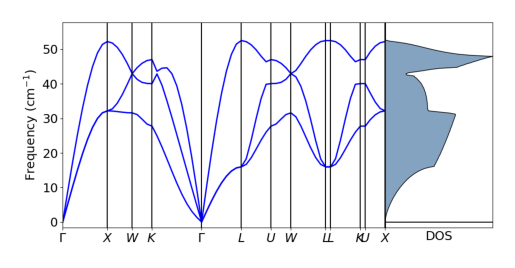

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(plt.imread("phonopy_bands_cu.png"))
plt.show()

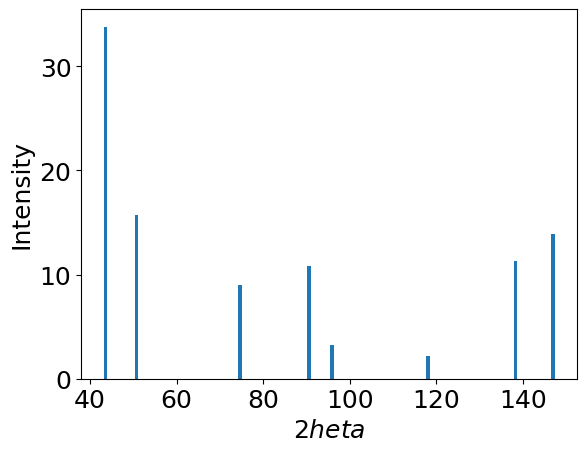

In [ ]:
# X-ray diffraction
from jarvis.analysis.diffraction.xrd import XRD
two_thetas, d_hkls, intensities = XRD().simulate(atoms=atoms)
plt.bar(two_thetas,intensities)
plt.xlabel('2$\theta$')
plt.ylabel('Intensity')
plt.show()

In [ ]:
thermal_prop.keys()

dict_keys(['temperatures', 'free_energy', 'entropy', 'heat_capacity'])

In [ ]:
from ase import Atom, Atoms
import numpy as np
import matplotlib.pyplot as plt
model_path = wt10_path() #default_path()
calc = AlignnAtomwiseCalculator(path=model_path)

lattice_params = np.linspace(3.5, 3.8)
fcc_energies = []
ready = True
for a in lattice_params:
    atoms = Atoms([Atom('Cu', (0, 0, 0))],
                  cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                           [0.0, 1.0, 1.0],
                                           [1.0, 0.0, 1.0]]),
                 pbc=True)

    atoms.set_tags(np.ones(len(atoms)))

    atoms.calc = calc

    e = atoms.get_potential_energy()
    fcc_energies.append(e)

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/alignnff_wt10


Check if EV curves are smooth

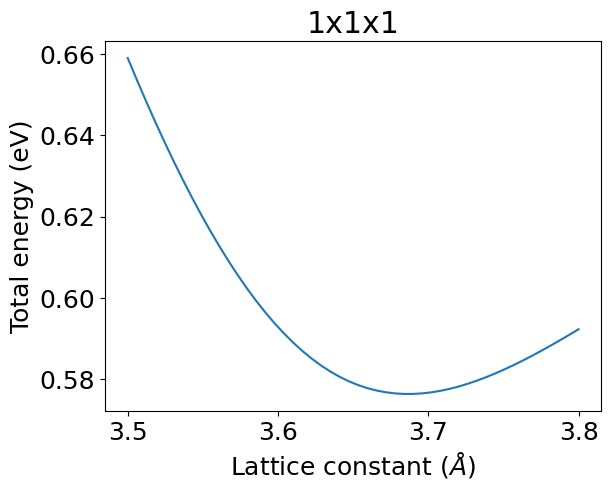

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lattice_params, fcc_energies)
plt.title('1x1x1')
plt.xlabel('Lattice constant ($\AA$)')
plt.ylabel('Total energy (eV)')
plt.show()

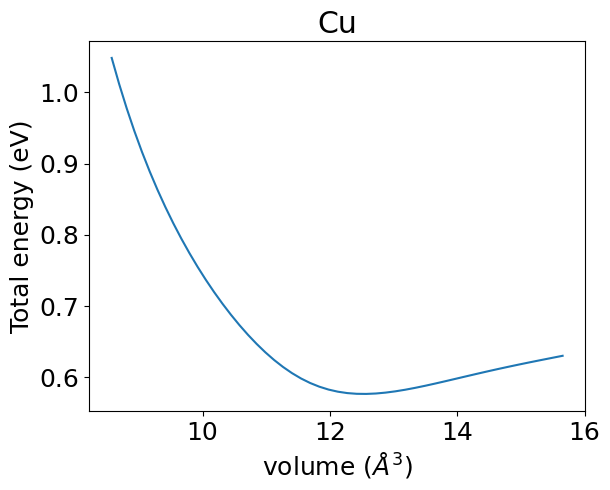

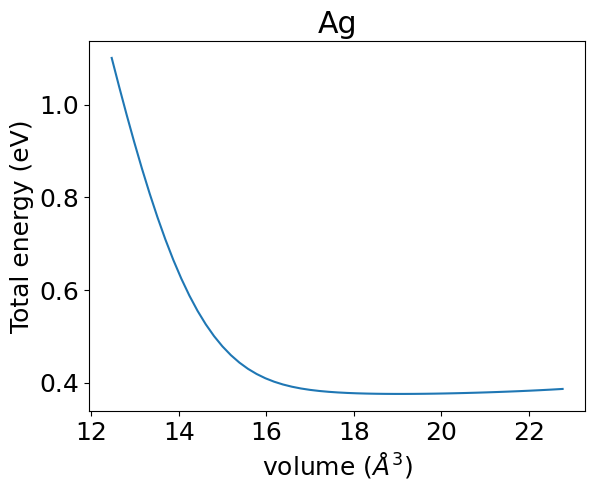

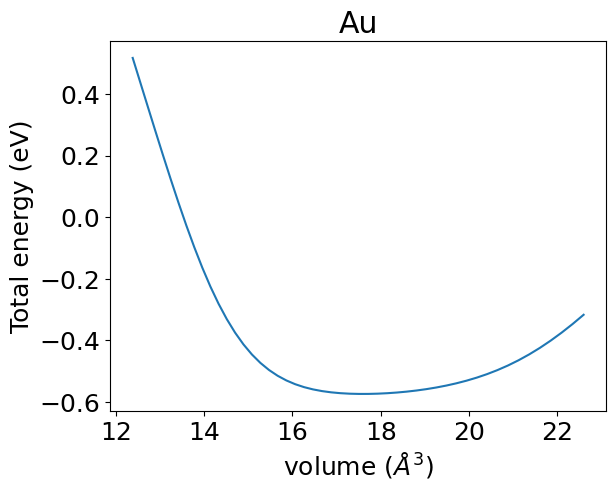

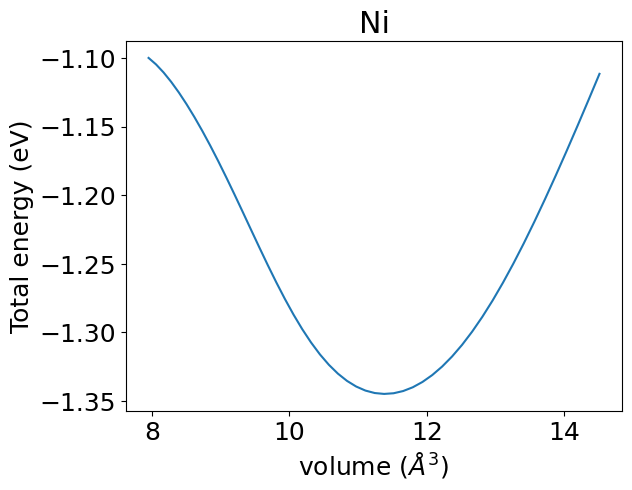

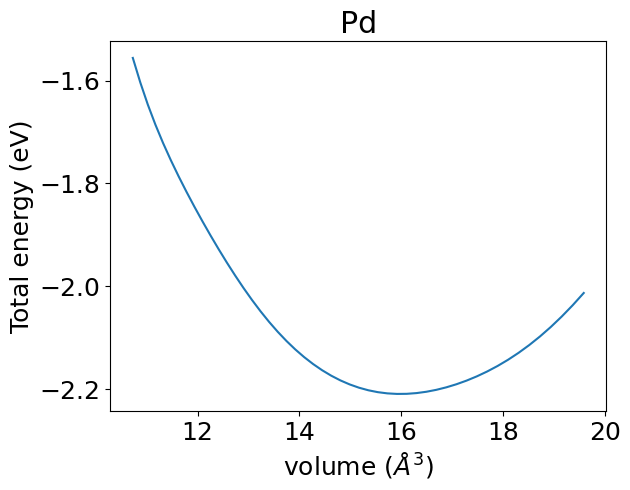

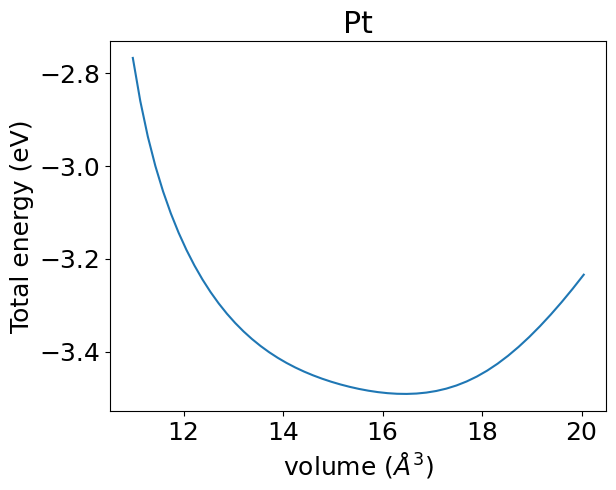

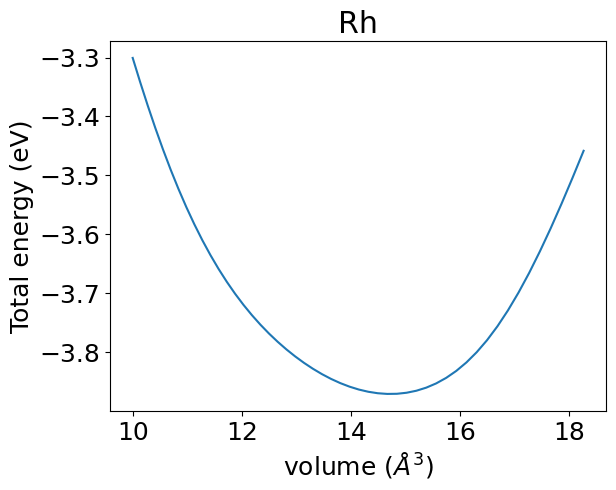

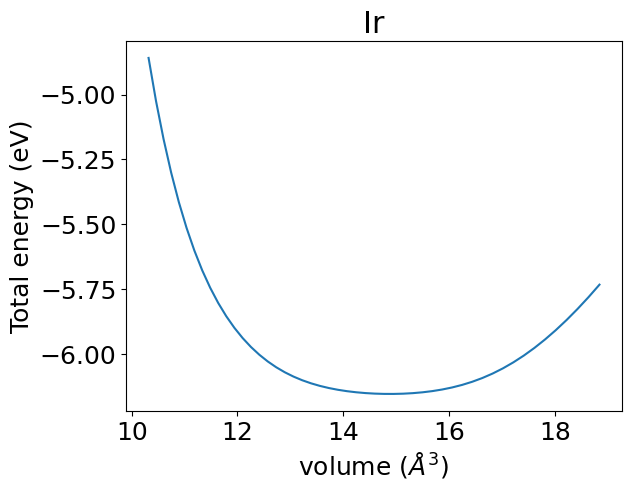

In [ ]:
from ase import data
for metal in ['Cu', 'Ag', 'Au', 'Ni', 'Pd', 'Pt', 'Rh', 'Ir']:
    a = data.reference_states[data.atomic_numbers[metal]]['a']
    LC = np.linspace(0.9 * a, 1.1 * a)
    vols, energies = [], []
    for a in LC:
        atoms = Atoms([Atom(metal, (0, 0, 0))],
                      cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                               [0.0, 1.0, 1.0],
                                               [1.0, 0.0, 1.0]]),
                     pbc=True)

        atoms.set_tags(np.ones(len(atoms)))

        atoms.calc = calc

        e = atoms.get_potential_energy()
        vols += [atoms.get_volume()]
        energies.append(e)
    plt.figure()
    plt.plot(vols, energies)
    plt.title(metal)
    plt.xlabel('volume ($\AA^3$)')
    plt.ylabel('Total energy (eV)');

Using ALIGNN-FF pretrained model to get unrelaxed energy and relaxed structure

Check phonons

dir_path /content/alignn/alignn/ff/alignnff_fd


100%|██████████| 15.0M/15.0M [00:01<00:00, 9.15MiB/s]


model_path /content/alignn/alignn/ff/alignnff_fd


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


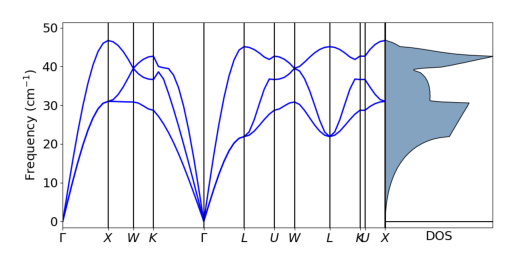

CPU times: user 17.8 s, sys: 1.06 s, total: 18.9 s
Wall time: 27.4 s


In [ ]:
%%time
from alignn.ff.ff import phonons
import numpy as np
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path,wt10_path,alignnff_fmult,fd_path,ForceField
from jarvis.core.atoms import ase_to_atoms
from ase import Atom, Atoms as AseAtoms
a = 3.597
atoms = AseAtoms([Atom('Cu', (0, 0, 0))],
              cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                        [0.0, 1.0, 1.0],
                                        [1.0, 0.0, 1.0]]),
              pbc=True)
ph_path=fd_path()
ph=phonons(model_path=ph_path, phonopy_bands_figname="phonopy_bands.png", atoms=ase_to_atoms(atoms))
%matplotlib inline
plt.axis('off')
plt.imshow(plt.imread("phonopy_bands.png"))
plt.show()

In [ ]:
from jarvis.core.atoms import ase_to_atoms
ase_to_atoms(atoms)

System
1.0
1.7985 1.7985 0.0
0.0 1.7985 1.7985
1.7985 0.0 1.7985
Cu 
1 
direct
0.0 0.0 0.0 Cu

In [ ]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="unrelaxed_energy"

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10
100% 15.0M/15.0M [00:01<00:00, 9.15MiB/s]
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10
/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
Energy(eV) (-11.776981830596924, array([[ 0.0000000e+00, -1.3969839e-09, -2.7939677e-09],
       [ 0.0000000e+00,  2.7357601e-07, -1.7777230e-03],
       [ 0.0000000e+00, -2.7706847e-07,  1.7777013e-03]], dtype=float32))


In [ ]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="optimize"

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10
OPTIMIZATION
/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
a= 1.678 Ang b= 2.906 Ang c= 6.221 Ang Volume= 60.658 amu/a3 PE=-11.77698 eV KE= 0.00000 eV T= 0.000 K 
a= 1.674 Ang b= 2.900 Ang c= 6.225 Ang Volume= 60.454 amu/a3 PE=-11.77964 eV KE= 0.00000 eV T= 0.000 K 
a= 1.668 Ang b= 2.888 Ang c= 6.235 Ang Volume= 60.059 amu/a3 PE=-11.78465 eV KE= 0.00000 eV T= 0.000 K 
a= 1.658 Ang b= 2.871 Ang c= 6.250 Ang Volume= 59.507 amu/a3 PE=-11.79133 eV KE= 0.00000 eV T= 0.000 K 
a= 1.646 An

In [ ]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="ev_curve"

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt10
/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
E [-11.59964204 -11.74018478 -11.77280259 -11.78283405 -11.78362942
 -11.77698183 -11.76358223 -11.74409294 -11.71869135 -11.68687463]
V [52.00698610745743, 53.66666028373519, 55.3612736919685, 57.09119028249023, 58.85677400563329, 60.6583888117305, 62.496398651114745, 64.3711674741189, 66.28305923107584, 68.23243787231843]


# 5. Train ALIGNN-FF on a new dataset

For a detailed example, check outthis notebook: https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Train_ALIGNNFF_Mlearn.ipynb

Convert calculations such as from vasprun.xml to id_prop.json format for ALIGNN-FF training, e.g. https://colab.research.google.com/gist/knc6/5513b21f5fd83a7943509ffdf5c3608b/make_id_prop.ipynb

Note: make add_reverse_forces True and lg_on_fly True

In [ ]:
!train_alignn.py --root_dir "alignn/examples/sample_data_ff" --config "alignn/examples/sample_data_ff/config_example_atomwise.json" --output_dir=temp

len dataset 50
MAX val: -24.52653862
MIN val: -42.04135008
MAD: 7.884625411000001
Baseline MAE: 11.991239256250003
data range -24.52653862 -42.04135008
Converting to graphs!
40it [00:00, 54.52it/s]
df        target  ...                                           stresses
0  -29.313096  ...  [[2.88305236, 0.0, 0.0], [0.0, 2.53508705, 0.6...
1  -29.312862  ...  [[3.64327667, 0.0, 0.0], [0.0, 1.66918758, -0....
2  -29.312159  ...  [[4.17873235, 0.0, 0.0], [0.0, 3.03267686, 0.6...
3  -29.312429  ...  [[3.94834115, 0.52115723, -0.58782616], [0.521...
4  -29.312428  ...  [[3.94677973, -0.52114892, 0.58782086], [-0.52...
5  -29.312791  ...  [[4.64789167, 0.0, 0.0], [0.0, 1.74371641, 1.2...
6  -29.311952  ...  [[3.11877316, 0.0, 0.0], [0.0, 3.03565406, -0....
7  -29.311899  ...  [[3.20798041, 0.0, 0.0], [0.0, 2.92951401, 0.8...
8  -29.312800  ...  [[4.59969418, 0.0, 0.0], [0.0, 1.7664801, -0.2...
9  -42.041350  ...  [[0.13527718, 0.0, 0.0], [0.0, 0.13527718, 0.0...
10 -42.002227  ...  [[-44.305

The generated model is saved as best_model.pt

In [ ]:
!ls -altr temp

total 47668
-rw-r--r-- 1 root root      241 Mar 19 06:09 prediction_results_test_set.csv
drwxr-xr-x 2 root root     4096 Mar 19 06:09 .
-rw-r--r-- 1 root root      778 Mar 19 06:09 prediction_results_train_set.csv
drwxr-xr-x 6 root root     4096 Mar 19 06:14 ..
-rw-r--r-- 1 root root       68 Mar 19 06:15 mad
-rw-r--r-- 1 root root      489 Mar 19 06:15 ids_train_val_test.json
-rw-r--r-- 1 root root       34 Mar 19 06:15 train_data_data_range
-rw-r--r-- 1 root root       34 Mar 19 06:15 val_data_data_range
-rw-r--r-- 1 root root       33 Mar 19 06:15 test_data_data_range
-rw-r--r-- 1 root root     2170 Mar 19 06:15 config.json
-rw-r--r-- 1 root root      202 Mar 19 06:15 history_train.json
-rw-r--r-- 1 root root 16177805 Mar 19 06:15 current_model.pt
-rw-r--r-- 1 root root 16177223 Mar 19 06:15 best_model.pt
-rw-r--r-- 1 root root   178483 Mar 19 06:15 Train_results.json
-rw-r--r-- 1 root root    17948 Mar 19 06:15 Val_results.json
-rw-r--r-- 1 root root      204 Mar 19 06:15 history_v

# 6. Additional examples:Training [JARVIS-DFT](https://jarvis.nist.gov/jarvisdft) 2D exfoliation energy model, training [QM9](http://quantum-machine.org/datasets/) U0 model

#Train a model for JARVIS-DFT 2D Exfoliation energy

There are quite a few datasets available here:https://jarvis-tools.readthedocs.io/en/master/databases.html
In the following example, we will use the JARVIS-DFT 2D dataset

Get data in id_prop.csv format

In [ ]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

cwd = os.getcwd() #current working directory
temp_dir_name = "DataDir_ExfoEnergy"
os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

dft_3d = jdata("dft_3d")
prop = "exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")
# count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
        # count += 1
        # if count == max_samples:
        #     break
f.close()

os.chdir(cwd)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 13.0MiB/s]


Loading the zipfile...
Loading completed.


In [ ]:
!ls -altr  DataDir_ExfoEnergy/*.vasp | wc -l


813


In [ ]:
 !wc -l DataDir_ExfoEnergy/id_prop.csv

813 DataDir_ExfoEnergy/id_prop.csv


In [ ]:
import time
t1=time.time()
!train_alignn.py --root_dir "DataDir_ExfoEnergy" --epochs 1 --batch_size 64 --config "alignn/examples/sample_data/config_example.json" --output_dir="ExfoEnOut"
t2=time.time()
print ('Time in s',t2-t1)

id_prop_csv_file exists True
len dataset 813
MAX val: 948.93
MIN val: 0.03
MAD: 62.629814227293544
Baseline MAE: 53.28148072174739
data range 948.93 0.03
Converting to graphs!
650it [00:11, 55.51it/s]
df                          jid  target                                              atoms
0       POSCAR-JVASP-10.vasp   83.78  {'lattice_mat': [[1.6777483798834445, -2.90594...
1    POSCAR-JVASP-60702.vasp   88.81  {'lattice_mat': [[9.067075684180468, -0.0, 0.0...
2    POSCAR-JVASP-28397.vasp    0.03  {'lattice_mat': [[0.0, -3.9587610833154616, 0....
3     POSCAR-JVASP-3534.vasp   71.05  {'lattice_mat': [[3.9274082409870625, 0.0, 0.0...
4      POSCAR-JVASP-323.vasp   89.57  {'lattice_mat': [[3.413342172498346, 0.0, 0.0]...
..                       ...     ...                                                ...
645  POSCAR-JVASP-29304.vasp   94.30  {'lattice_mat': [[6.442061375822732, -0.0, 0.0...
646  POSCAR-JVASP-29728.vasp   38.76  {'lattice_mat': [[3.704728408598396, 0.0005419...
647 

In [ ]:
!ls ExfoEnOut

best_model.pt		 last_model.pt			   train_data_data_range
config.json		 mad				   Train_results.json
current_model.pt	 prediction_results_test_set.csv   val_data_data_range
history_train.json	 prediction_results_train_set.csv  Val_results.json
history_val.json	 test_data_data_range
ids_train_val_test.json  Test_results.json


Here checkpoints are the model parameter files that can be loaded in torch library to make predictions such as [this example](https://github.com/usnistgov/alignn/blob/main/alignn/scripts/predict.py).

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('/content/alignn/ExfoEnOut/prediction_results_test_set.csv')

These are predictions on 10 % held dataset that the model has never seen

In [ ]:
df

,id,target,prediction
0,POSCAR-JVASP-4657.vasp,57.080002,47.001801
1,POSCAR-JVASP-368.vasp,55.490002,47.031479
2,POSCAR-JVASP-578.vasp,96.629997,46.959553
3,POSCAR-JVASP-9389.vasp,247.889999,47.397125
4,POSCAR-JVASP-4660.vasp,8.220000,47.278667
...,...,...,...
76,POSCAR-JVASP-57459.vasp,253.800003,47.176769
77,POSCAR-JVASP-12888.vasp,52.169998,47.512371
78,POSCAR-JVASP-58999.vasp,234.050003,47.431438
79,POSCAR-JVASP-4645.vasp,100.849998,47.170200


In [ ]:
# !pip install matplotlib==3.1.3

Obviously, this is just an example. For production runs, please select larger dataset, batch size, epochs etc.

Text(0, 0.5, 'ALIGNN predictions (meV)')

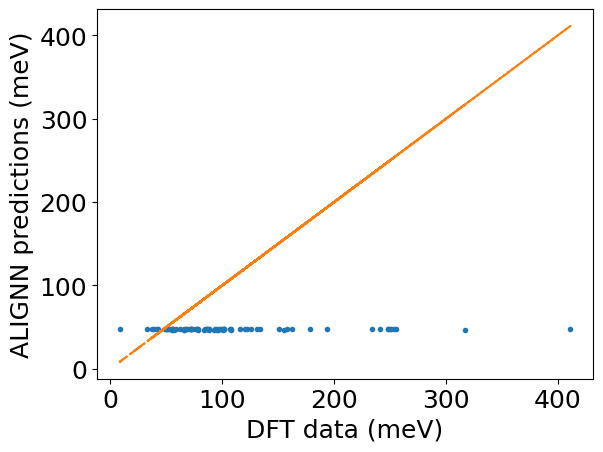

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df['target'],df['prediction'],'.')
plt.plot(df['target'],df['target'],'-.')
plt.xlabel('DFT data (meV)')
plt.ylabel('ALIGNN predictions (meV)')

In [ ]:
# from jarvis.db.figshare import data as jdata
# from jarvis.core.atoms import Atoms
# import os

# temp_dir_name = "DataDir_QM9_U0"
# os.makedirs(temp_dir_name)
# os.chdir(temp_dir_name)

# dft_3d = jdata("qm9_std_jctc") #jdata("dft_3d")
# prop = "U0" #"exfoliation_energy" #"optb88vdw_bandgap"
# f = open("id_prop.csv", "w")
# # count = 0
# for i in dft_3d:
#     atoms = Atoms.from_dict(i["atoms"])
#     jid = i["id"]
#     poscar_name = "POSCAR-" + jid + ".vasp"
#     target = i[prop]
#     if target != "na":
#         atoms.write_poscar(poscar_name)
#         f.write("%s,%6f\n" % (poscar_name, target))
#         # count += 1
#         # if count == max_samples:
#         #     break
# f.close()

# os.chdir(cwd)

In [ ]:
pwd

'/content/alignn'

In [ ]:
!ls

alignn		    ExfoEnOut	 opt.traj	       pyproject.toml  temp
alignn_ff.log	    LICENSE.rst  phonopy_bands_cu.png  README.md
DataDir_ExfoEnergy  opt.log	 phonopy_bands.png     setup.py


Changing the cut-off in config_example.json as 5,  n_train as 110000, n_val as 10000, n_test as 10829

In [ ]:
# from jarvis.db.jsonutils import loadjson, dumpjson
# config = loadjson("alignn/examples/sample_data/config_example.json")
# config['cutoff'] = 5.0
# config['n_train'] = 110000
# config['n_val'] = 10000
# config['n_test'] = 10829
# dumpjson(data=config, filename="config_qm9.json")

Run for 1000 epochs instead of 5 here to get reasonable performance/MAE

In [ ]:
# import time
# t1=time.time()
# !train_folder.py --root_dir "DataDir_QM9_U0" --epochs 5 --batch_size 64 --config "config_qm9.json" --output_dir="DataDir_QM9U0out"
# t2=time.time()
# print ('Time in s',t2-t1)

# Generate an id_prop.json from vasprun.xml files

In [ ]:
import requests,zipfile,io,tempfile,os
from jarvis.io.vasp.outputs import Vasprun
from jarvis.db.figshare import get_jid_data
from jarvis.db.jsonutils import dumpjson, loadjson
# We will download vasprun.xml from JARVIS-DFT elastic tensor calculations for Silicon (JVASP-1002)
jid = 'JVASP-1002'
x=get_jid_data(jid=jid,dataset='dft_3d')
for i in x['raw_files']:
  if 'FD-ELAST' in i:
    print(i)
    tmp = i.split(".zip,")[1]
    r = requests.get(tmp)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    vrun_path = z.read("vasprun.xml").decode("utf-8")
    fd, path = tempfile.mkstemp()
    with os.fdopen(fd, "w") as tmp:
        tmp.write(vrun_path)
    vrun_elast = Vasprun(path)
for i in x['raw_files']:
  if 'DFT-SCF' in i:
    print(i)
    tmp = i.split(".zip,")[1]
    r = requests.get(tmp)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    vrun_path = z.read("vasprun.xml").decode("utf-8")
    fd, path = tempfile.mkstemp()
    with os.fdopen(fd, "w") as tmp:
        tmp.write(vrun_path)
    vrun_scf = Vasprun(path)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
FD-ELAST,JVASP-1002.zip,https://ndownloader.figshare.com/files/22975514
DFT-SCF,JVASP-1002.zip,https://ndownloader.figshare.com/files/23127296


In [ ]:
x['raw_files']

['FD-ELAST,JVASP-1002.zip,https://ndownloader.figshare.com/files/22975514',
 'DFPT,JVASP-1002.zip,https://ndownloader.figshare.com/files/22941809',
 'OPT-LOPTICS,JVASP-1002.zip,https://ndownloader.figshare.com/files/24035894',
 'OPT-Bandst,JVASP-1002.zip,https://ndownloader.figshare.com/files/23713301',
 'TBMBJ,JVASP-1002.zip,https://ndownloader.figshare.com/files/23571836',
 'DFT-SCF,JVASP-1002.zip,https://ndownloader.figshare.com/files/23127296',
 'WANN,JVASP-1002.zip,https://ndownloader.figshare.com/files/23102750']

In [ ]:
jid='JVASP-1002'
forces = vrun_elast.all_forces
energies = vrun_elast.all_energies
stresses = vrun_elast.all_stresses
structures = vrun_elast.all_structures
count = 0
mem=[]
for i, j, k, s in zip(energies, forces, stresses, structures):
    count += 1
    jid_c = jid + "_elastic_" + str(count)
    info = {}
    info["jid"] = jid_c
    info["energy"] = i / s.num_atoms
    info["forces"] = j.tolist()
    info["stresses"] = k.tolist()
    info["atoms"] = s.to_dict()
    mem.append(info)



In [ ]:
len(mem)

15

In [ ]:

forces = vrun_scf.all_forces
energies = vrun_scf.all_energies
stresses = vrun_scf.all_stresses
structures = vrun_scf.all_structures
count = 0
mem=[]
for i, j, k, s in zip(energies, forces, stresses, structures):
    count += 1
    jid_c = jid + "_scf_" + str(count)
    info = {}
    info["jid"] = jid_c
    info["energy"] = i / s.num_atoms
    info["forces"] = j.tolist()
    info["stresses"] = k.tolist()
    info["atoms"] = s.to_dict()
    mem.append(info)



In [ ]:
len(mem)

4

In [ ]:
dumpjson(data=mem, filename="id_prop.json")

# 7: Add results to JARVIS-Leaderboard


Checkout the notebook: https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/alignn_jarvis_leaderboard.ipynb

In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==0.21.0
aiohttp==3.8.5
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
alignn==2023.7.10
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.4.0
arviz==0.15.1
ase==3.22.1
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.10
blosc2==2.0.0
bokeh==3.1.1
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.9
certifi==2023.7.22
cffi==1.15.1
chardet==4.0.0
charset-normalizer==3.2.0
chex==0.1.7
click==8.1.6
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.1.1
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==3.4.8
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.1
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7